In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

%matplotlib inline
#plt.style.use('ggplot')

# Comparar historico distintas estrategias

In [2]:
# Descarga datos historicos multifondos AFP Cuprum
url_data = 'https://rawgit.com/collabmarket/data_afp/master/data/VC-CUPRUM.csv'
afp_name = url_data.split('-')[-1].split('.')[0] # Nombre de la afp
karg_csv = dict(delimiter=';', decimal=',', index_col=0, parse_dates=True)
afp = pd.read_csv(url_data, **karg_csv) # Crea DataFrame con los datos
afp.dropna(inplace=True) # Elimina filas sin datos de para todos los fondos

## Felices y Forrados 

Fuente: https://www.felicesyforrados.cl/resultados/

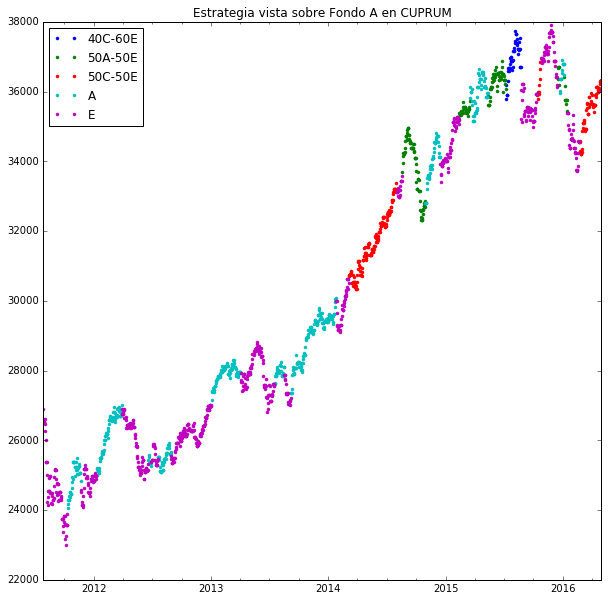

In [3]:
karg_csv = dict(delimiter=';', decimal=',', index_col='DATE', parse_dates=True)
df = pd.read_csv('data/estrategias.csv', **karg_csv)
fyf = df.resample('D').ffill()
df = pd.concat([afp,fyf], axis=1)
gb = df[['A','B','C','E','FyF']].groupby('FyF')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10),ax=ax)
plt.legend(loc=2)

## Estrategia base propuesta

Es la estrategia más simple de cambio de fondo A-E, cualquier estrategia más complicada debería entregar mejor rentabilidad, en caso contrario está haciendo overfitting o es inconsistente.
Fuente https://github.com/collabmarket/algorithms_afp

In [4]:
# Funcion para definir rent basado en estrategia
def label_rent(row):
    if row['estrategia'] == 'E->A':
        return row['A']
    if row['estrategia'] == 'A->E':
        return row['E']
    else:
        return pd.np.nan

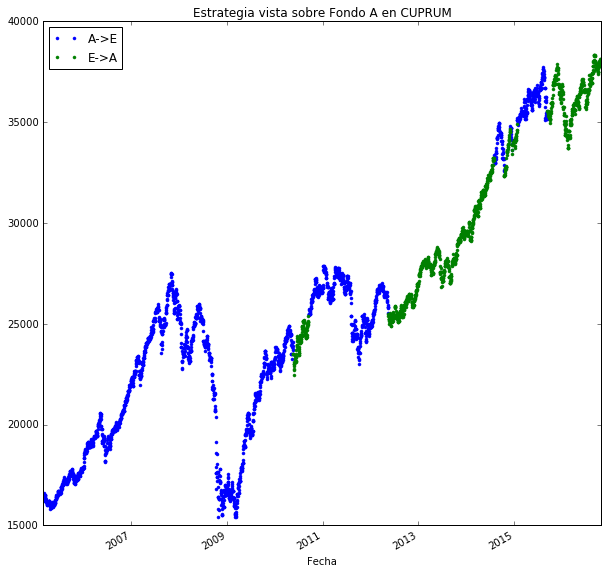

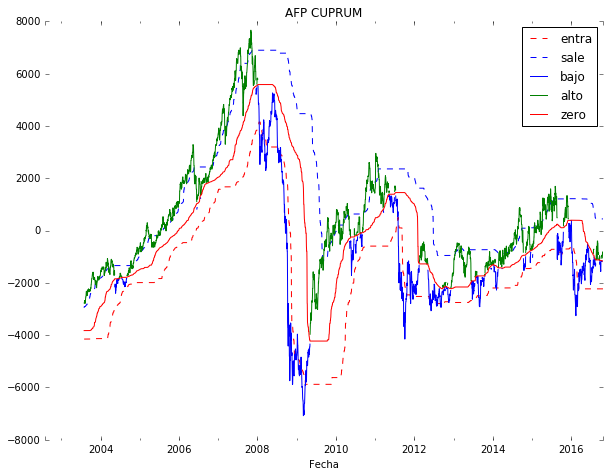

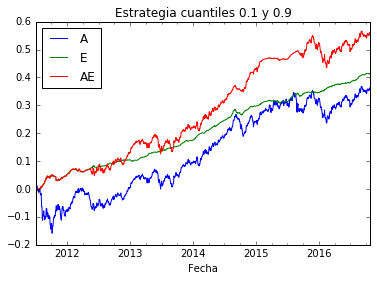

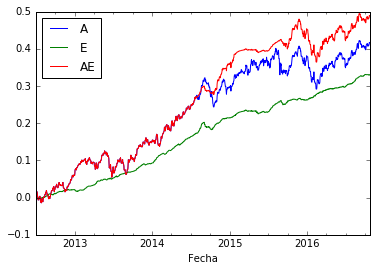

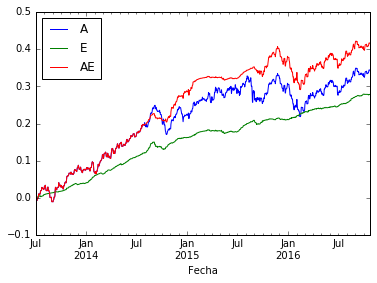

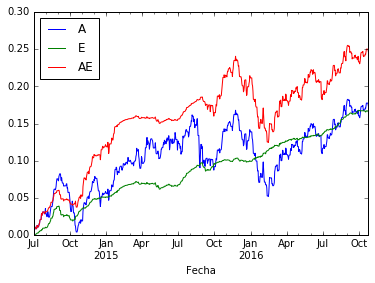

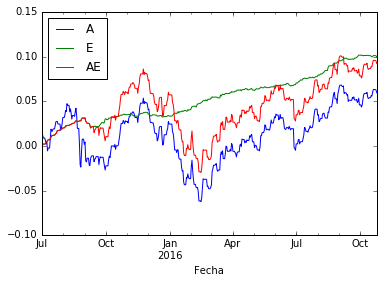

Estrategia cuantiles 0.1 y 0.9
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.556904
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.485994
                   A        E        AE
Fecha                                  
2016-10-25  0.340528  0.27694  0.413083
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.246535
                   A         E        AE
Fecha                                   
2016-10-25  0.059545  0.099597  0.092218


In [5]:
# PARAMETROS
q_superior = 0.9
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)

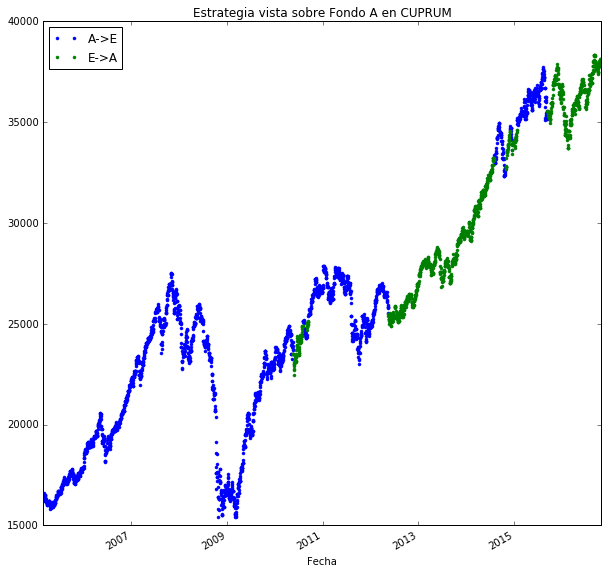

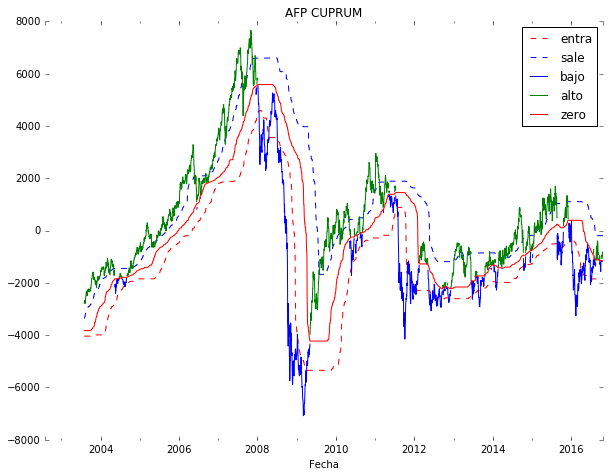

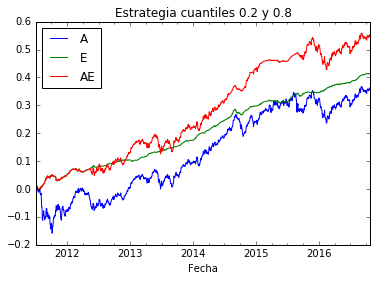

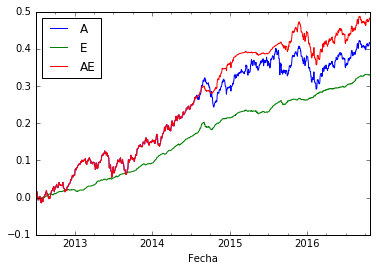

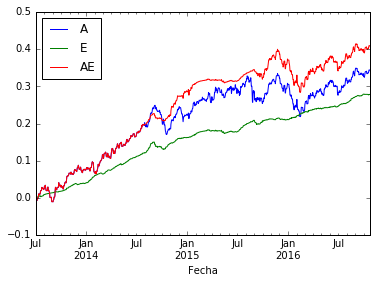

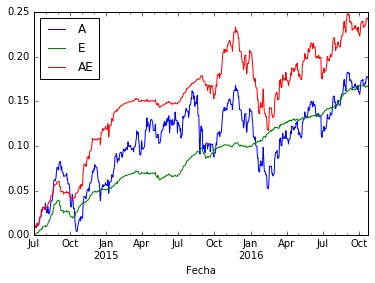

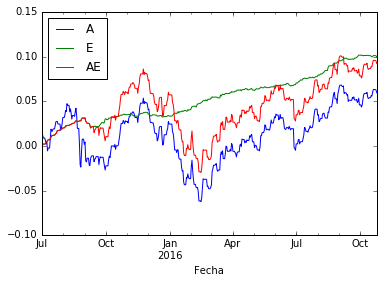

Estrategia cuantiles 0.2 y 0.8
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.549693
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.478783
                   A        E        AE
Fecha                                  
2016-10-25  0.340528  0.27694  0.405871
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.239323
                   A         E        AE
Fecha                                   
2016-10-25  0.059545  0.099597  0.092218


In [6]:
# PARAMETROS
q_superior = 0.8
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)

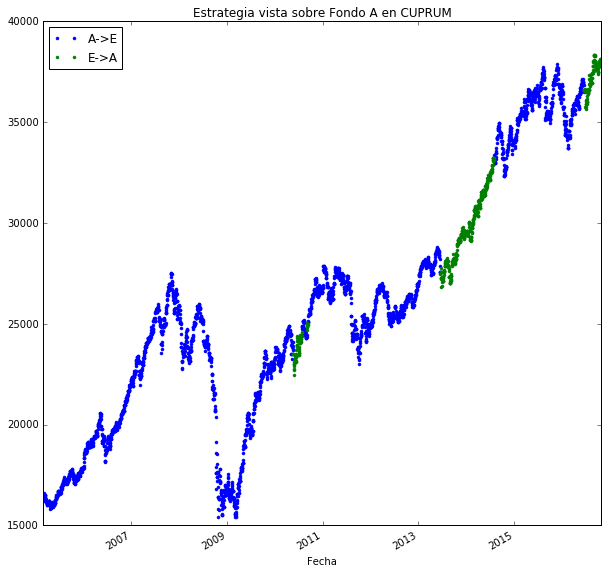

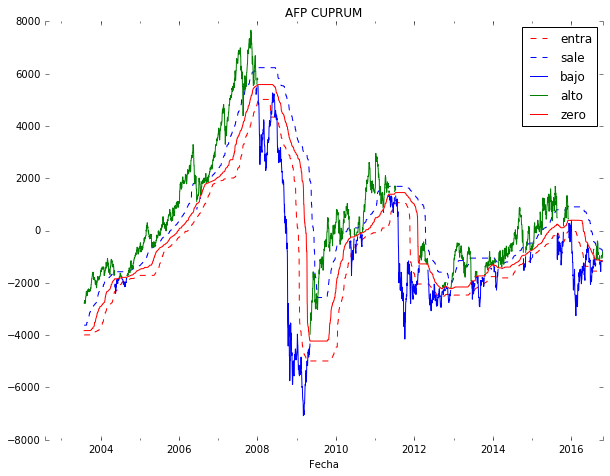

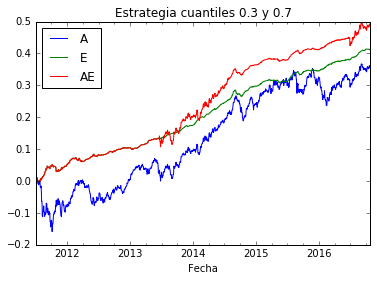

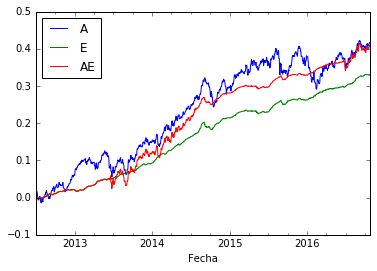

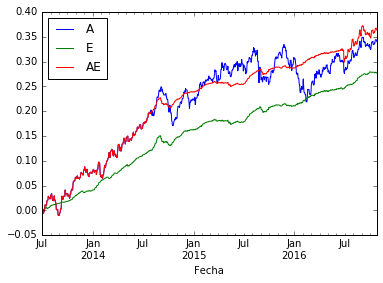

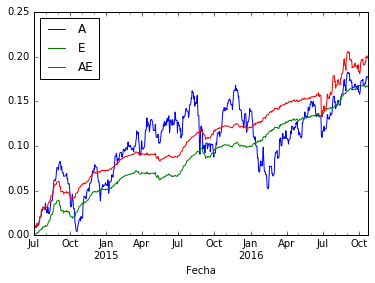

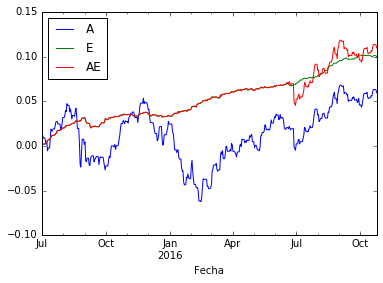

Estrategia cuantiles 0.3 y 0.7
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.488831
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.405846
                   A        E        AE
Fecha                                  
2016-10-25  0.340528  0.27694  0.363561
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.197013
                   A         E      AE
Fecha                                 
2016-10-25  0.059545  0.099597  0.1098


In [7]:
# PARAMETROS
q_superior = 0.7
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)

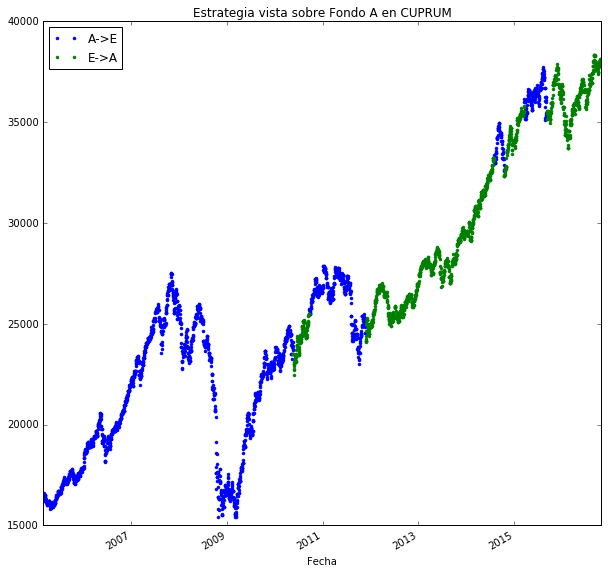

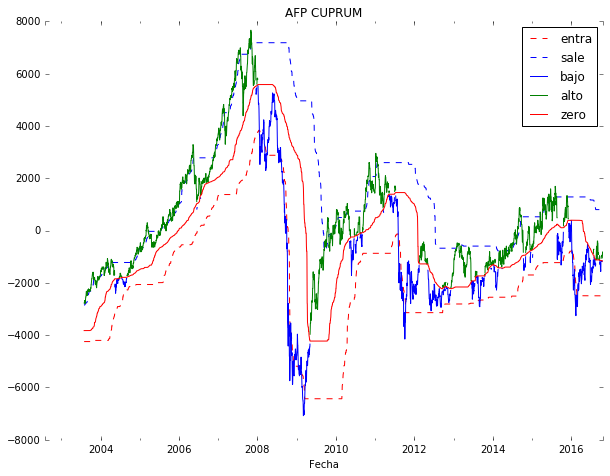

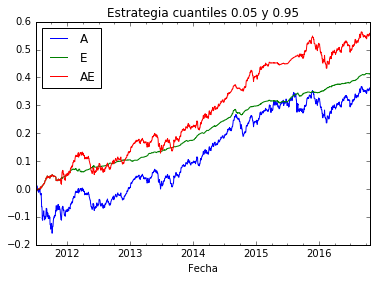

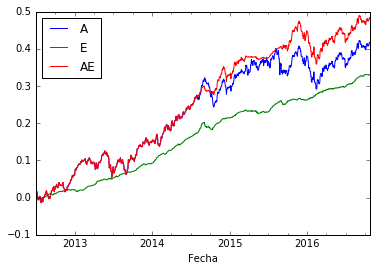

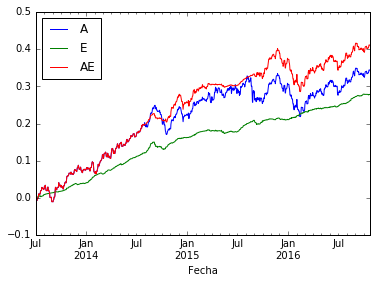

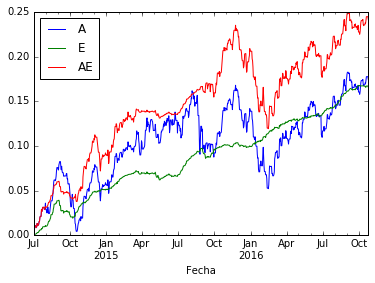

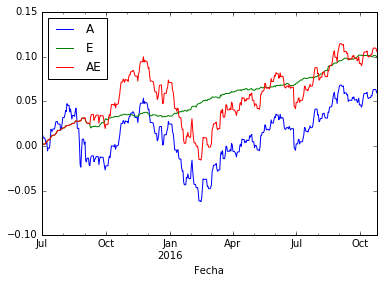

Estrategia cuantiles 0.05 y 0.95
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.554466
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.480651
                   A        E       AE
Fecha                                 
2016-10-25  0.340528  0.27694  0.40774
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.241192
                   A         E        AE
Fecha                                   
2016-10-25  0.059545  0.099597  0.105994


In [8]:
# PARAMETROS
q_superior = 0.95
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)

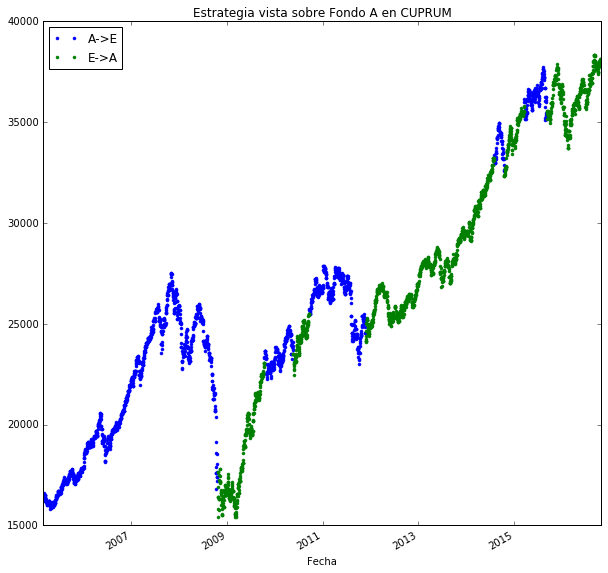

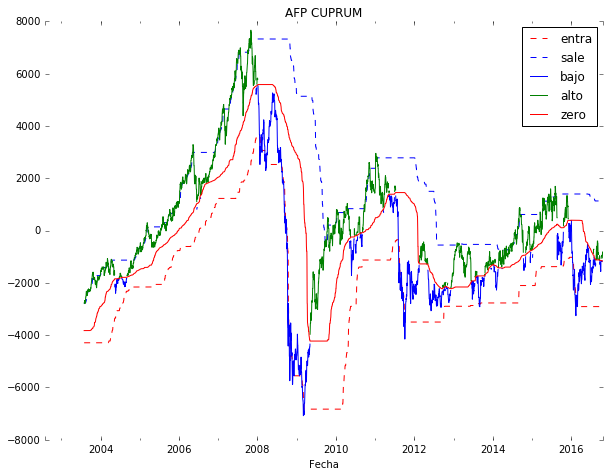

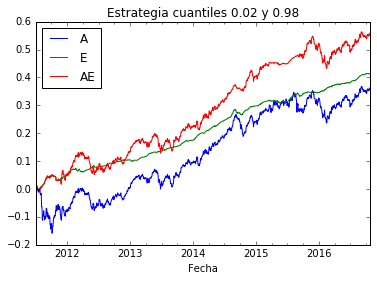

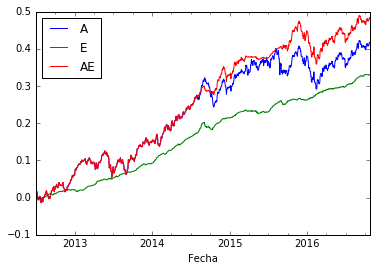

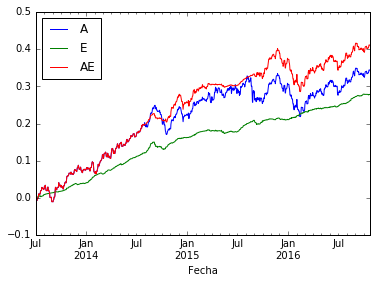

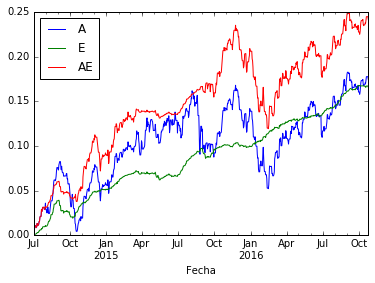

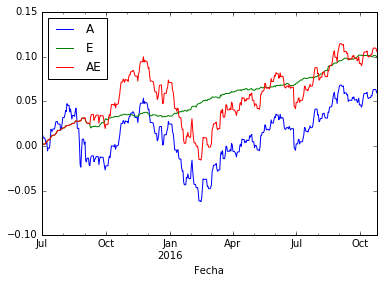

Estrategia cuantiles 0.02 y 0.98
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.554466
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.480651
                   A        E       AE
Fecha                                 
2016-10-25  0.340528  0.27694  0.40774
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.241192
                   A         E        AE
Fecha                                   
2016-10-25  0.059545  0.099597  0.105994


In [9]:
# PARAMETROS
q_superior = 0.98
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)

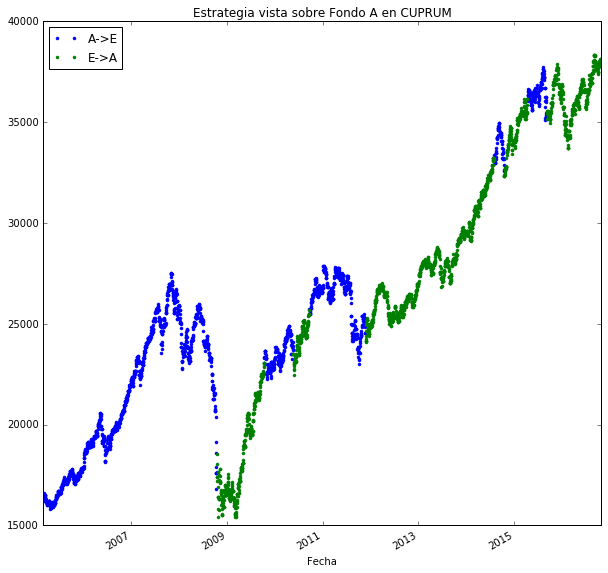

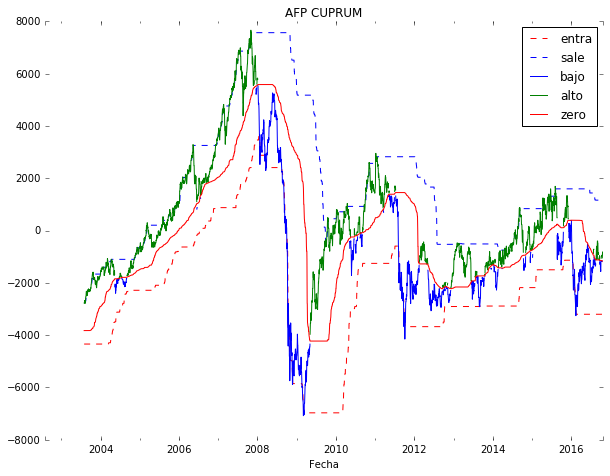

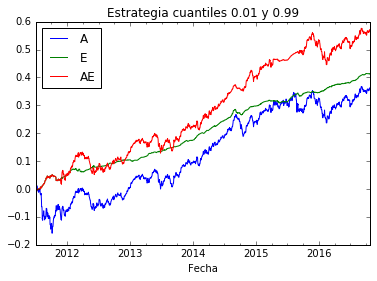

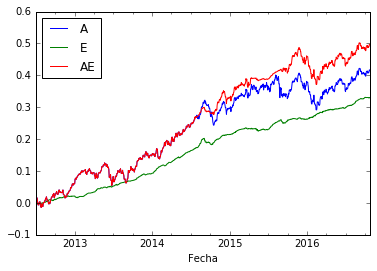

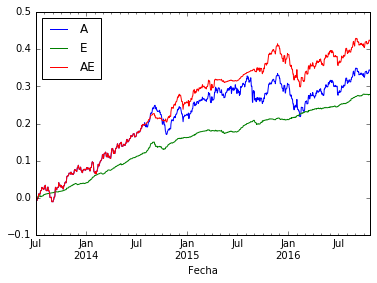

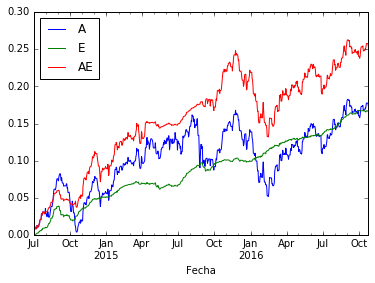

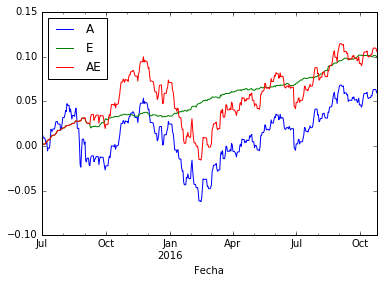

Estrategia cuantiles 0.01 y 0.99
                   A         E        AE
Fecha                                   
2016-10-25  0.358552  0.411857  0.567273
                   A         E        AE
Fecha                                   
2016-10-25  0.413439  0.328872  0.493458
                   A        E        AE
Fecha                                  
2016-10-25  0.340528  0.27694  0.420546
                  A         E        AE
Fecha                                  
2016-10-25  0.17398  0.165544  0.253998
                   A         E        AE
Fecha                                   
2016-10-25  0.059545  0.099597  0.105994


In [10]:
# PARAMETROS
q_superior = 0.99
q_inferior = 1 - q_superior
largo_plazo = 365
corto_plazo = 15
rate_corto = 1
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=largo_plazo,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: (elejimos cuantil inferior ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_inferior)
# Criterios de Salida a renta fija
# Parametros: (elejimos cuantil superior ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=largo_plazo,center=False).quantile(quantile=q_superior)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(corto_plazo)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = pd.np.nan
# Segnales de largo plazo
# POR SIMPLICIDAD NO SE USAN SEGNALES DE LARGO PLAZO
#afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
#afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de corto plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > rate_corto),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & ((afp.rate < -rate_corto) | (afp.rate > rate_corto)),'estrategia'] = 'A->E'
# Propaga señal de corto plazo hacia adelante
afp['estrategia'] = afp.estrategia.ffill()
# Calcula rentabilidad diaria
rent_afp = afp.loc[:,['A','E']].pct_change()
# Copia estrategia en DataFrame de rentabilidad
rent_afp['estrategia'] = afp.estrategia
# Define rentabilidad AE con funcion label_rent a cada fila.
rent_afp['AE'] = rent_afp.apply(lambda row: label_rent(row),axis=1)

# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)
plt.show()
# Grafo limites entra, neutro y sale
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]
fig, ax = plt.subplots(figsize=(10,7.5))
afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'], ax=ax)
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), style=['b','g','r'], ax=ax)
ax.set_frame_on(False)  # no visible frame
plt.show()
# Evalua para cada año
rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().plot(title='Estrategia cuantiles %s y %s'%(q_inferior, q_superior))
rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().plot()
rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().plot()
plt.show()
print 'Estrategia cuantiles %s y %s'%(q_inferior, q_superior)
print rent_afp.loc['2011-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2012-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2013-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2014-07-01':,['A','E','AE']].cumsum().tail(1)
print rent_afp.loc['2015-07-01':,['A','E','AE']].cumsum().tail(1)